<a href="https://colab.research.google.com/github/sreeshma15/ForecastingWaterConsumption/blob/main/MYPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print(" ML ENVIRONMENT SETUP COMPLETED")

 ML ENVIRONMENT SETUP COMPLETED


In [55]:
import sklearn
import matplotlib

print("pandas", pd.__version__)
print("numpy", np.__version__)
print("seaborn", sns.__version__)
print("matplotlib", matplotlib.__version__)
print("sklearn", sklearn.__version__)

pandas 2.2.2
numpy 2.0.2
seaborn 0.13.2
matplotlib 3.10.0
sklearn 1.6.1


In [56]:
print("\n=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===")
print("=" * 60)

# Load the organized dataset
df = pd.read_csv('/content/drive/MyDrive/WaterConsumptionDataset(Finalized).csv')

print("1.1 DATASET STRUCTURE EXAMINATION")
print("-" * 40)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print("\n1.2 COMPREHENSIVE DATA PROFILING")
print("-" * 40)

print("Missing Values Analysis:")
print(df.isnull().sum())

print(f"\nBasic Statistics:")
print(df.describe())

print(f"\nCategorical Variables Summary:")
categorical_cols = ['Country', 'Water Scarcity Level']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())
    else:
        print(f"\nColumn '{col}' not found in the DataFrame.")


print("\n1.3 TEMPORAL AND GEOGRAPHICAL ANALYSIS")
print("-" * 40)

print(f"Year Range: {df['Year'].min()} to {df['Year'].max()}")
print(f"Number of Countries: {df['Country'].nunique()}")
print(f"Countries: {df['Country'].unique()}")

# Check data distribution by country and year
country_years = df.groupby('Country')['Year'].agg(['min', 'max', 'count'])
print(f"\nCountry-wise Data Distribution:")
print(country_years)


=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===
1.1 DATASET STRUCTURE EXAMINATION
----------------------------------------
Dataset Shape: (700, 15)
Columns: ['Year', 'Country code', 'Country', 'Population', 'Total Water Consumption(Billion Cubic Meters)', 'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)', 'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)', 'Water Scarcity Level', 'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries']

First 5 rows:
   Year  Country code Country  Population  \
0  1990           356   India   405123000   
1  1990           156   China  1130000000   
2  1990           840     USA   249000000   
3  1990            76  Brazil   149000000   
4  1990           643  Russia   148000000   

   Total Water Consumption(Billion Cubic Meters)  \
0                                          350.0   
1                                          502.0   

In [57]:
print("\n=== PHASE 2: DATA CLEANING FOR GLOBAL DATASET ===")
print("=" * 60)

# 2.1 Comprehensive Missing Values Analysis
print("2.1 Global Missing Values Analysis")
print("-" * 40)

# Initial missing values assessment
print("Initial Missing Values by Column:")
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_analysis = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_percentage
})
print(missing_analysis[missing_analysis['Missing_Count'] > 0])

# 2.2 Handle Missing Values Strategically
print("\n2.2 Strategic Missing Value Handling")
print("-" * 40)

# Critical columns - cannot have missing values
critical_columns = ['Country', 'Year', 'Country code']
for col in critical_columns:
    if col in df.columns and df[col].isnull().any():
        print(f"Critical column '{col}' has {df[col].isnull().sum()} missing values - DROPPING ROWS")
        df = df.dropna(subset=[col])

# Country-specific handling - DO NOT default to 'India'
if 'Country' in df.columns:
    unique_countries = df['Country'].nunique()
    print(f"Dataset contains {unique_countries} unique countries")

    # Show countries with missing data (if any)
    if df['Country'].isnull().any():
        print(" Missing country values found - these rows will be dropped")
        df = df.dropna(subset=['Country'])

# Numerical columns - impute with median by country group
numerical_columns = [
    'Total Water Consumption(Billion Cubic Meters)',
    'Per Capita Water Use (Liters per Day)',
    'Agricultural Water Use (%)',
    'Industrial Water Use (%)',
    'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)',
    'Groundwater Depletion Rate (%)',
    'Number of dams',
    'Reservoir_Capacity_TMC',
    'Number_of_Industries'
]

print("\nHandling missing numerical values by country groups...")
for col in numerical_columns:
    if col in df.columns and df[col].isnull().any():
        missing_before = df[col].isnull().sum()
        # Impute with country-specific median
        df[col] = df.groupby('Country')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # If still missing (e.g., entire country missing), use global median
        df[col] = df[col].fillna(df[col].median())
        missing_after = df[col].isnull().sum()
        print(f"{col}: {missing_before} → {missing_after} missing values")




=== PHASE 2: DATA CLEANING FOR GLOBAL DATASET ===
2.1 Global Missing Values Analysis
----------------------------------------
Initial Missing Values by Column:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

2.2 Strategic Missing Value Handling
----------------------------------------
Dataset contains 20 unique countries

Handling missing numerical values by country groups...


In [58]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

# # Set style for better visuals
# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

# class BasicWaterConsumptionVisualizer:
#     def __init__(self, df):
#         """
#         Initialize the visualizer with global water consumption data
#         """
#         self.df = df.copy()
#         self._preprocess_data()

#         # Set up color scheme
#         self.colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3E885B']

#     def _preprocess_data(self):
#         """Preprocess the dataset"""
#         # Clean population column (remove commas and convert to numeric)
#         self.df['Population'] = self.df['Population'].astype(str).str.replace(',', '').astype(float)

#         # Convert percentage columns to proper format
#         percentage_cols = ['Agricultural Water Use (%)', 'Industrial Water Use (%)',
#                           'Household Water Use (%)', 'Groundwater Depletion Rate (%)']
#         for col in percentage_cols:
#             self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

#         # Convert year to datetime for better plotting
#         self.df['Year'] = pd.to_datetime(self.df['Year'], format='%Y')

#     def create_basic_dashboard(self, figsize=(20, 15)):
#         """
#         Create a basic dashboard with essential plots
#         """
#         fig, axes = plt.subplots(2, 3, figsize=figsize)
#         # fig.suptitle('Basic Water Consumption Analysis Dashboard', fontsize=20, fontweight='bold', y=0.95)

#         # Plot 1: Total Consumption Trends (Top 5 Countries)
#         self._plot_basic_consumption_trend(axes[0, 0])

#         # Plot 2: Per Capita Water Use (Latest Year)
#         self._plot_basic_per_capita(axes[0, 1])

#         # Plot 3: Sector Usage Distribution
#         self._plot_basic_sector_usage(axes[0, 2])

#         # Plot 4: Population vs Consumption
#         self._plot_population_consumption_trend(axes[1, 0])

#         # Plot 5: Water Scarcity Distribution
#         self._plot_basic_scarcity(axes[1, 1])

#         # Plot 6: Rainfall Analysis
#         self._plot_basic_rainfall(axes[1, 2])

#         plt.tight_layout()
#         return fig

#     def _plot_basic_consumption_trend(self, ax):
#         """Plot basic consumption trends for top 5 countries"""
#         top_countries = self.df.groupby('Country')['Total Water Consumption(Billion Cubic Meters)'].max().nlargest(5).index
#         filtered_df = self.df[self.df['Country'].isin(top_countries)]

#         for country in top_countries:
#             country_data = filtered_df[filtered_df['Country'] == country]
#             ax.plot(country_data['Year'].dt.year, country_data['Total Water Consumption(Billion Cubic Meters)'],
#                    label=country, linewidth=2.5, alpha=0.8, marker='o')

#         ax.set_title('Water Consumption Trends\n(Top 5 Countries)', fontsize=14, fontweight='bold')
#         ax.set_xlabel('Year')
#         ax.set_ylabel('Total Consumption\n(Billion Cubic Meters)')
#         ax.legend()
#         ax.grid(True, alpha=0.3)

#     def _plot_basic_per_capita(self, ax):
#         """Plot per capita water use for latest year"""
#         latest_year = self.df['Year'].max()
#         latest_data = self.df[self.df['Year'] == latest_year]

#         # Get top 8 countries by per capita usage
#         top_countries = latest_data.nlargest(8, 'Per Capita Water Use (Liters per Day)')

#         bars = ax.barh(top_countries['Country'], top_countries['Per Capita Water Use (Liters per Day)'],
#                       color=self.colors, alpha=0.7)

#         ax.set_title(f'Per Capita Water Use\n({latest_year.year})', fontsize=14, fontweight='bold')
#         ax.set_xlabel('Liters per Day')
#         ax.bar_label(bars, fmt='%.0f', padding=3)
#         ax.grid(True, alpha=0.3, axis='x')

#     def _plot_basic_sector_usage(self, ax):
#         """Plot water usage distribution by sector"""
#         sector_cols = ['Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)']
#         avg_usage = self.df[sector_cols].mean()

#         colors = ['#2E86AB', '#F18F01', '#A23B72']
#         wedges, texts, autotexts = ax.pie(avg_usage, labels=['Agriculture', 'Industry', 'Household'],
#                                          autopct='%1.1f%%', colors=colors, startangle=90)

#         for autotext in autotexts:
#             autotext.set_color('white')
#             autotext.set_fontweight('bold')

#         ax.set_title('Global Water Usage by Sector', fontsize=14, fontweight='bold')

#     def _plot_population_consumption_trend(self, ax):
#         """Plot population and consumption trends over time for top countries"""
#         # Get top 5 countries by latest consumption
#         latest_year = self.df['Year'].max()
#         top_countries = self.df[self.df['Year'] == latest_year].nlargest(5, 'Total Water Consumption(Billion Cubic Meters)')['Country'].values

#         # Create a second y-axis for population
#         ax2 = ax.twinx()

#         # Define colors for the two y-axes
#         consumption_color = '#2E86AB'
#         population_color = '#C73E1D'

#         for country in top_countries:
#             country_data = self.df[self.df['Country'] == country].sort_values('Year')

#             # Plot consumption on primary y-axis
#             ax.plot(country_data['Year'].dt.year,
#                    country_data['Total Water Consumption(Billion Cubic Meters)'],
#                    label=f'{country} - Consumption', color=consumption_color,
#                    linewidth=2.5, alpha=0.7, marker='o')

#             # Plot population on secondary y-axis
#             ax2.plot(country_data['Year'].dt.year,
#                     country_data['Population']/1e6,  # Convert to millions
#                     label=f'{country} - Population', color=population_color,
#                     linewidth=2.5, alpha=0.7, marker='s', linestyle='--')

#         # Set labels and titles
#         ax.set_xlabel('Year', fontsize=12, fontweight='bold')
#         ax.set_ylabel('Total Water Consumption\n(Billion Cubic Meters)',
#                      fontsize=12, fontweight='bold', color=consumption_color)
#         ax2.set_ylabel('Population (Millions)',
#                       fontsize=12, fontweight='bold', color=population_color)

#         ax.set_title('Population & Consumption Trends\n(Top 5 Countries)',
#                    fontsize=14, fontweight='bold')

#         # Set grid
#         ax.grid(True, alpha=0.3)

#         # Create combined legend
#         lines1, labels1 = ax.get_legend_handles_labels()
#         lines2, labels2 = ax2.get_legend_handles_labels()
#         ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

#         # Set colors for y-axis labels
#         ax.tick_params(axis='y', labelcolor=consumption_color)
#         ax2.tick_params(axis='y', labelcolor=population_color)

#     def _plot_basic_scarcity(self, ax):
#         """Plot water scarcity distribution"""
#         scarcity_counts = self.df['Water Scarcity Level'].value_counts()

#         bars = ax.bar(scarcity_counts.index, scarcity_counts.values,
#                      color=self.colors[:len(scarcity_counts)], alpha=0.7)

#         ax.set_title('Water Scarcity Level Distribution', fontsize=14, fontweight='bold')
#         ax.set_ylabel('Number of Records')
#         ax.bar_label(bars, fmt='%d')
#         ax.grid(True, alpha=0.3, axis='y')

#     def _plot_basic_rainfall(self, ax):
#         """Plot basic rainfall analysis"""
#         latest_year = self.df['Year'].max()
#         latest_data = self.df[self.df['Year'] == latest_year]

#         # Get countries with highest rainfall
#         high_rainfall = latest_data.nlargest(6, 'Rainfall Impact (Annual Precipitation in mm)')

#         bars = ax.barh(high_rainfall['Country'], high_rainfall['Rainfall Impact (Annual Precipitation in mm)'],
#                       color='#2E86AB', alpha=0.7)

#         ax.set_title(f'Highest Rainfall Countries\n({latest_year.year})', fontsize=14, fontweight='bold')
#         ax.set_xlabel('Annual Precipitation (mm)')
#         ax.bar_label(bars, fmt='%.0f', padding=3)
#         ax.grid(True, alpha=0.3, axis='x')

#     def create_correlation_analysis(self, figsize=(12, 8)):
#         """Create a separate correlation analysis"""
#         numerical_cols = ['Population', 'Total Water Consumption(Billion Cubic Meters)',
#                          'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)',
#                          'Rainfall Impact (Annual Precipitation in mm)',
#                          'Groundwater Depletion Rate (%)']

#         corr_matrix = self.df[numerical_cols].corr()

#         fig, ax = plt.subplots(figsize=figsize)
#         im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

#         # Set ticks and labels
#         ax.set_xticks(range(len(numerical_cols)))
#         ax.set_yticks(range(len(numerical_cols)))
#         short_labels = ['Population', 'Total Consumption', 'Per Capita', 'Agriculture %', 'Rainfall', 'Groundwater %']
#         ax.set_xticklabels(short_labels, rotation=45, ha='right')
#         ax.set_yticklabels(short_labels)

#         # Add correlation values
#         for i in range(len(numerical_cols)):
#             for j in range(len(numerical_cols)):
#                 ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
#                        ha='center', va='center', fontsize=10, fontweight='bold',
#                        color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

#         ax.set_title('Correlation Matrix: Key Water Consumption Factors', fontsize=16, fontweight='bold')
#         plt.colorbar(im, ax=ax, shrink=0.8)
#         plt.tight_layout()
#         return fig

#     def create_country_comparison(self, countries=None, figsize=(15, 10)):
#         """Create country comparison charts"""
#         if countries is None:
#             countries = ['India', 'China', 'USA', 'Brazil', 'Russia']

#         filtered_df = self.df[self.df['Country'].isin(countries)]
#         latest_year = self.df['Year'].max()
#         latest_data = filtered_df[filtered_df['Year'] == latest_year]

#         fig, axes = plt.subplots(2, 2, figsize=figsize)
#         fig.suptitle(f'Country Comparison Analysis ({latest_year.year})', fontsize=18, fontweight='bold')

#         # Plot 1: Total Consumption
#         bars1 = axes[0, 0].bar(latest_data['Country'], latest_data['Total Water Consumption(Billion Cubic Meters)'],
#                              color=self.colors, alpha=0.7)
#         axes[0, 0].set_title('Total Water Consumption', fontweight='bold')
#         axes[0, 0].set_ylabel('Billion Cubic Meters')
#         axes[0, 0].bar_label(bars1, fmt='%.0f')
#         axes[0, 0].tick_params(axis='x', rotation=45)

#         # Plot 2: Per Capita Usage
#         bars2 = axes[0, 1].bar(latest_data['Country'], latest_data['Per Capita Water Use (Liters per Day)'],
#                              color=self.colors, alpha=0.7)
#         axes[0, 1].set_title('Per Capita Water Use', fontweight='bold')
#         axes[0, 1].set_ylabel('Liters per Day')
#         axes[0, 1].bar_label(bars2, fmt='%.0f')
#         axes[0, 1].tick_params(axis='x', rotation=45)

#         # Plot 3: Sector Distribution
#         width = 0.25
#         x = np.arange(len(countries))

#         agri = latest_data['Agricultural Water Use (%)'].values
#         industrial = latest_data['Industrial Water Use (%)'].values
#         household = latest_data['Household Water Use (%)'].values

#         axes[1, 0].bar(x - width, agri, width, label='Agriculture', alpha=0.7)
#         axes[1, 0].bar(x, industrial, width, label='Industry', alpha=0.7)
#         axes[1, 0].bar(x + width, household, width, label='Household', alpha=0.7)

#         axes[1, 0].set_title('Water Usage by Sector', fontweight='bold')
#         axes[1, 0].set_ylabel('Percentage (%)')
#         axes[1, 0].set_xticks(x)
#         axes[1, 0].set_xticklabels(countries, rotation=45)
#         axes[1, 0].legend()

#         # Plot 4: Groundwater Depletion
#         bars4 = axes[1, 1].bar(latest_data['Country'], latest_data['Groundwater Depletion Rate (%)'],
#                              color=self.colors, alpha=0.7)
#         axes[1, 1].set_title('Groundwater Depletion', fontweight='bold')
#         axes[1, 1].set_ylabel('Depletion Rate (%)')
#         axes[1, 1].bar_label(bars4, fmt='%.1f')
#         axes[1, 1].tick_params(axis='x', rotation=45)

#         plt.tight_layout()
#         return fig

# # Usage example
# if __name__ == "__main__":
#     # Load your dataset
#     df = pd.read_csv('/content/drive/MyDrive/WaterConsumptionDataset(Finalized).csv')

#     # Create basic visualizer instance
#     visualizer = BasicWaterConsumptionVisualizer(df)

#     print("Creating basic dashboard...")
#     fig1 = visualizer.create_basic_dashboard()
#     plt.show()

#     print("Creating correlation analysis...")
#     fig2 = visualizer.create_correlation_analysis()
#     plt.show()

#     print("Creating country comparison...")
#     fig3 = visualizer.create_country_comparison()
#     plt.show()

#     # Save figures
#     fig1.savefig('basic_water_dashboard.png', dpi=300, bbox_inches='tight')
#     fig2.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
#     fig3.savefig('country_comparison.png', dpi=300, bbox_inches='tight')

#     print("Basic analysis completed successfully!")

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/WaterConsumptionDataset(Finalized).csv')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nBasic Info:")
print(df.info())







Dataset Shape: (700, 15)

Columns: ['Year', 'Country code', 'Country', 'Population', 'Total Water Consumption(Billion Cubic Meters)', 'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)', 'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)', 'Water Scarcity Level', 'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries']

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 15 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Year                                           700 non-null    int64  
 1   Country code                                   700 non-null    int64  
 2   Country                                        700 non-null    object 
 3   Population                                     700 non-null    

Correlation Matrix Shape: (12, 12)

Correlation Matrix:
                                                Year  Population  \
Year                                           1.000       0.084   
Population                                     0.084       1.000   
Total Water Consumption(Billion Cubic Meters)  0.080       0.939   
Per Capita Water Use (Liters per Day)         -0.092       0.537   
Agricultural Water Use (%)                    -0.072       0.043   
Industrial Water Use (%)                      -0.127       0.181   
Household Water Use (%)                        0.105      -0.018   
Rainfall Impact (Annual Precipitation in mm)  -0.020       0.020   
Groundwater Depletion Rate (%)                 0.201       0.002   
Number of dams                                 0.064       0.253   
Reservoir_Capacity_TMC                         0.048      -0.206   
Number_of_Industries                           0.253       0.101   

                                               Total Water 

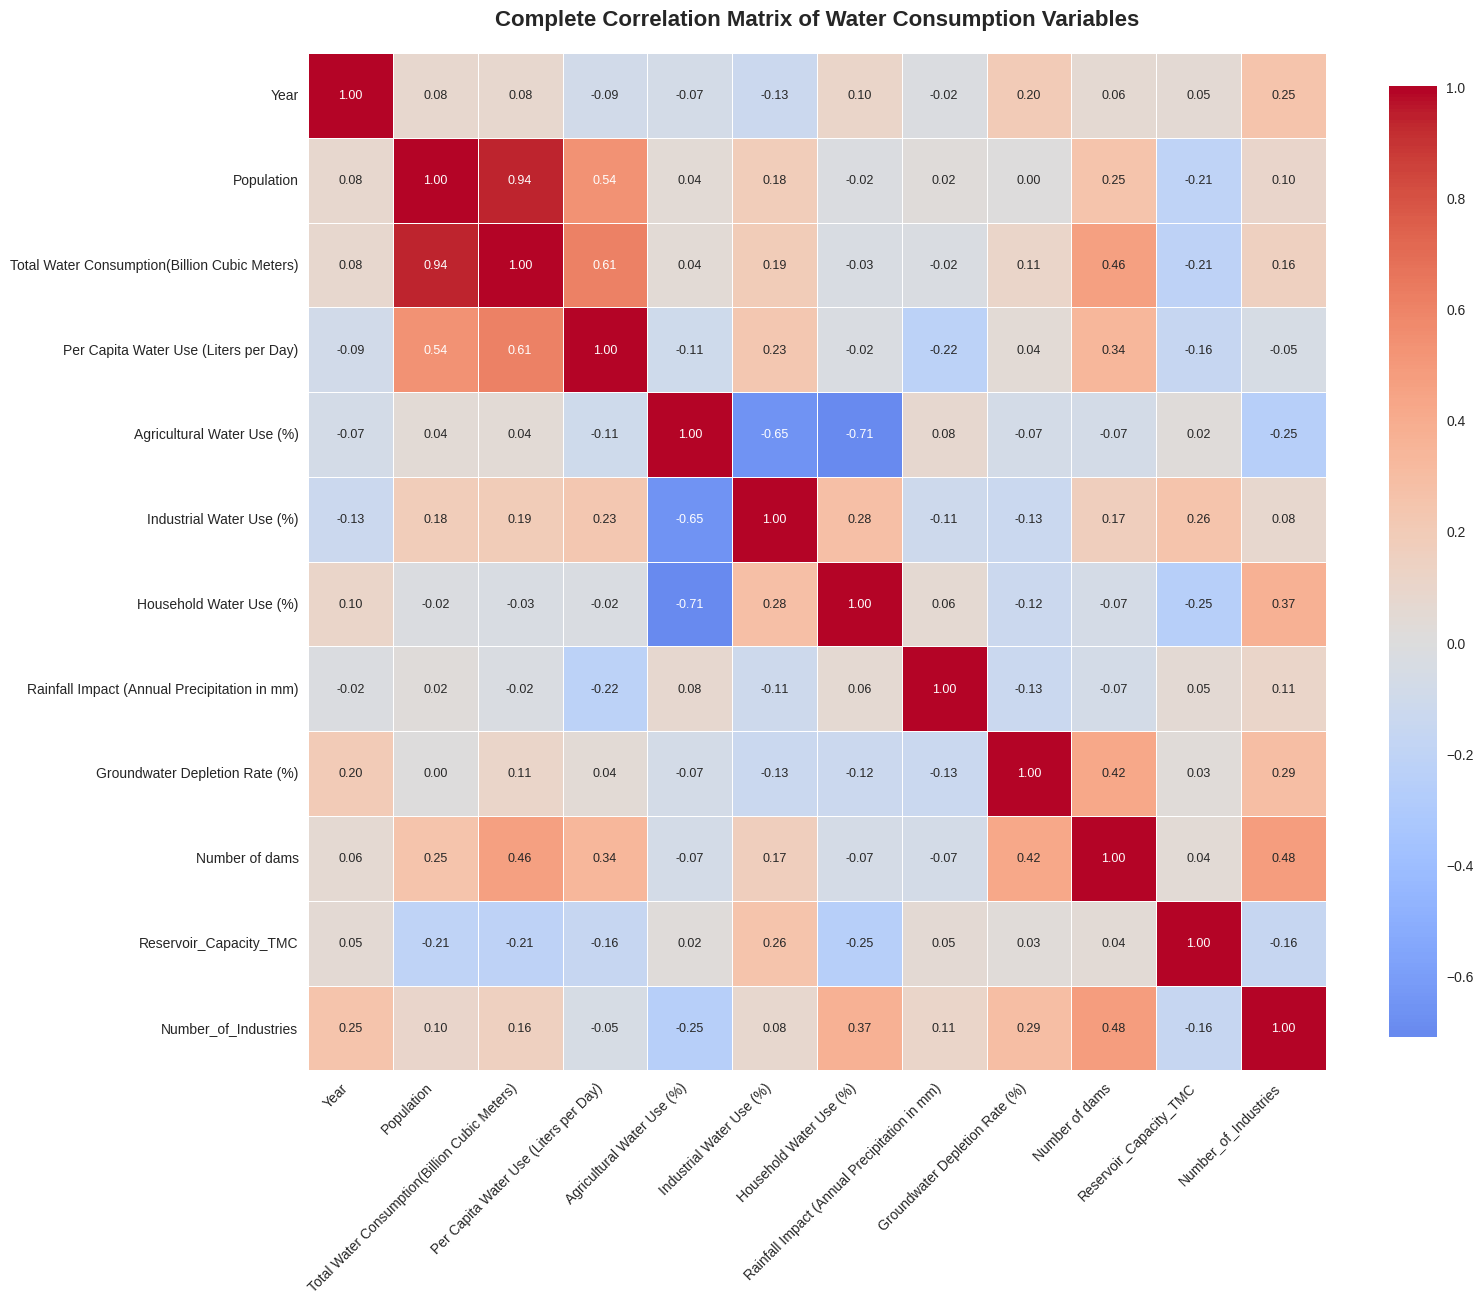

In [60]:
# Select numerical columns for correlation analysis
numerical_columns = [
    'Year', 'Population', 'Total Water Consumption(Billion Cubic Meters)',
    'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)',
    'Industrial Water Use (%)', 'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)',
    'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries'
]
# Create correlation matrix
correlation_matrix = df[numerical_columns].corr()

print("Correlation Matrix Shape:", correlation_matrix.shape)
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                     center=0, square=True, linewidths=0.5,
                     cbar_kws={"shrink": 0.8}, fmt='.2f',
                     annot_kws={"size": 9})

plt.title('Complete Correlation Matrix of Water Consumption Variables',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




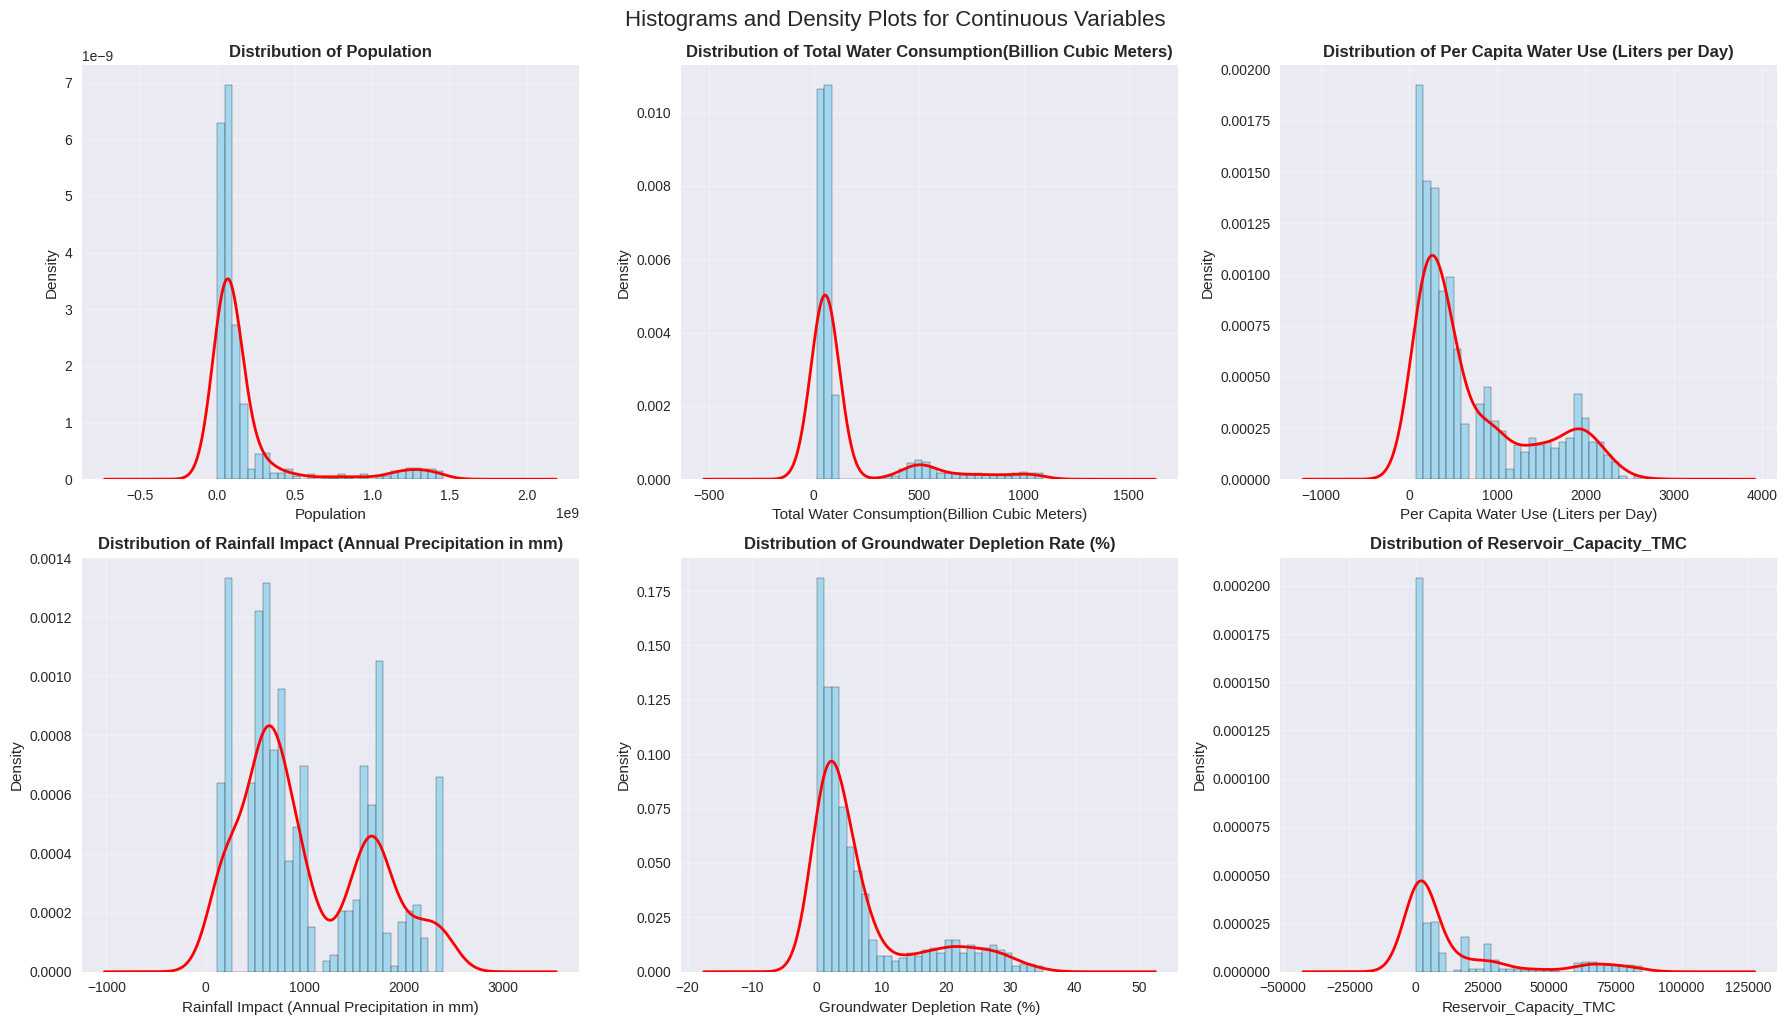

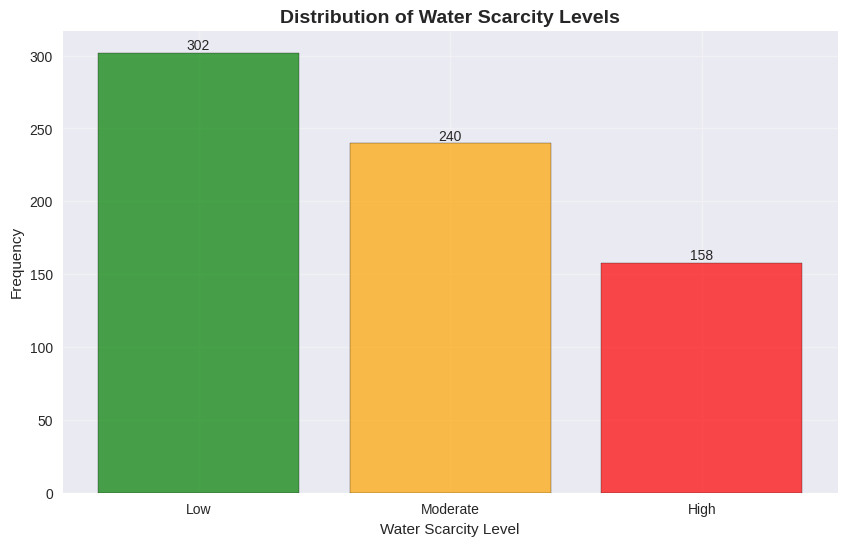

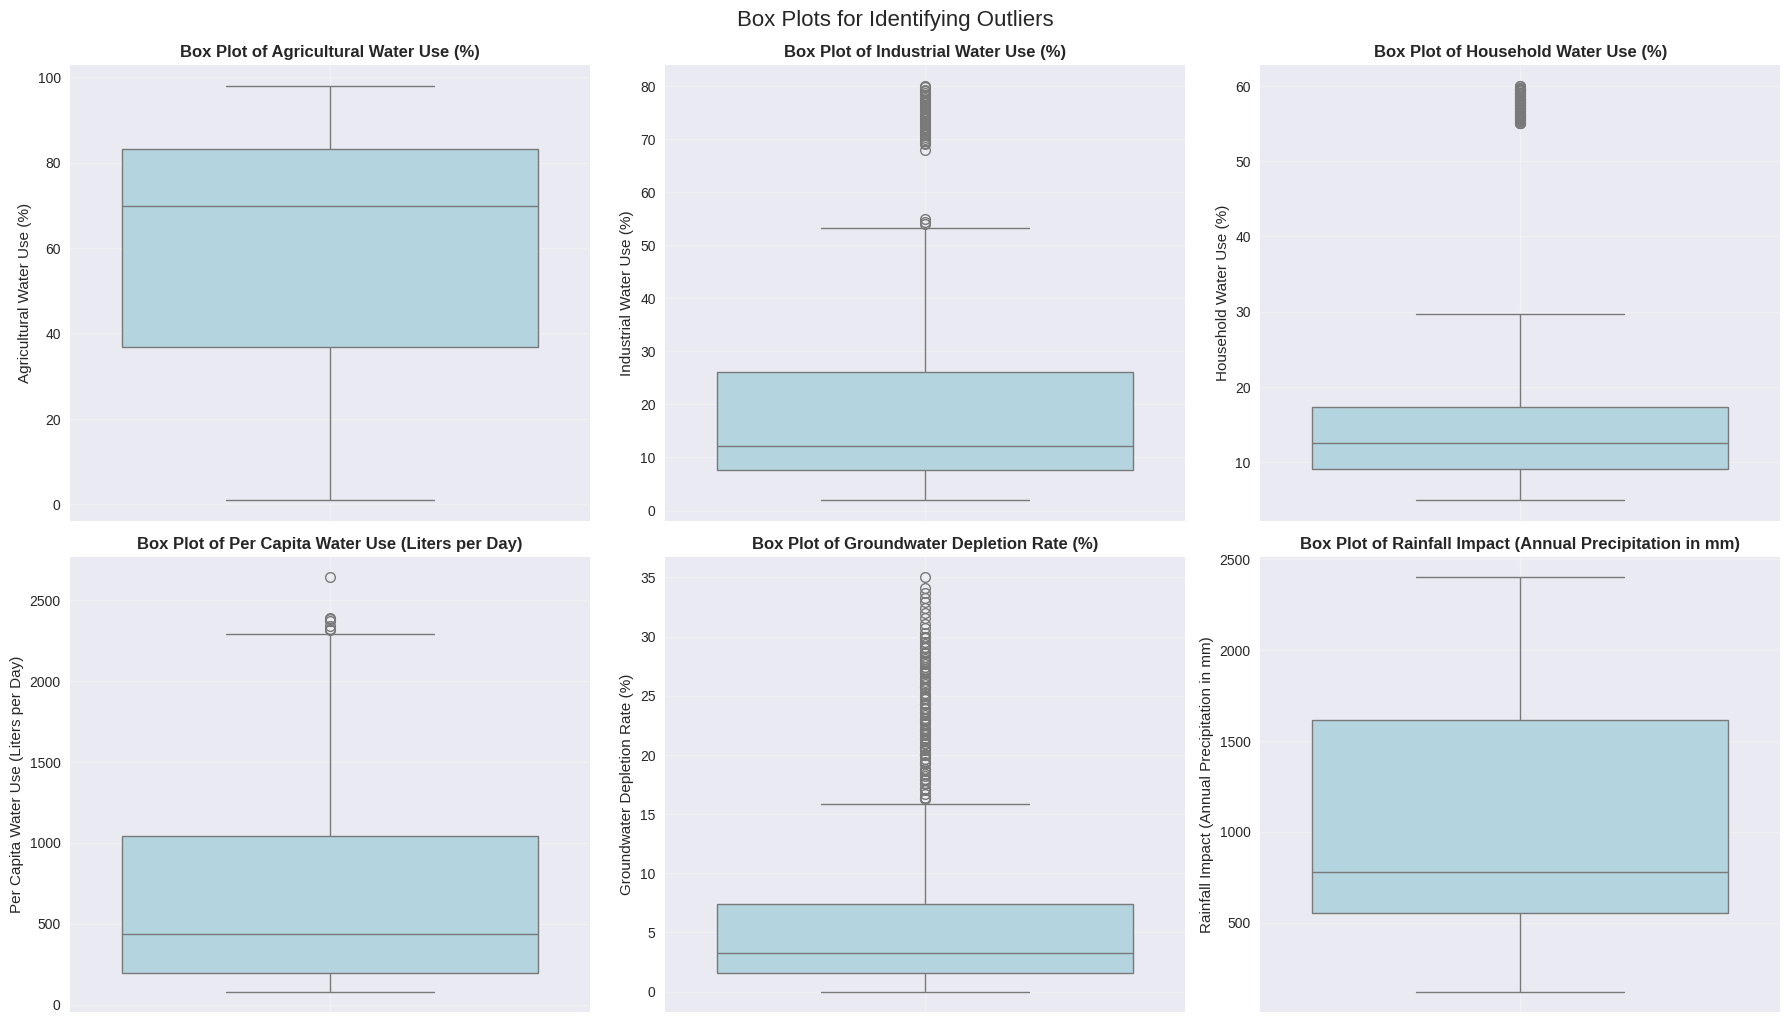

In [61]:
# A1. Histograms & Density Plots for key continuous variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
continuous_vars = ['Population', 'Total Water Consumption(Billion Cubic Meters)',
                  'Per Capita Water Use (Liters per Day)', 'Rainfall Impact (Annual Precipitation in mm)',
                  'Groundwater Depletion Rate (%)', 'Reservoir_Capacity_TMC']

for i, var in enumerate(continuous_vars):
    row, col = i // 3, i % 3
    # Histogram with density curve
    axes[row, col].hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    df[var].plot.density(ax=axes[row, col], color='red', linewidth=2)
    axes[row, col].set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Density')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Histograms and Density Plots for Continuous Variables', fontsize=16, y=1.02)
plt.show()

# A2. Bar Chart for Water Scarcity Level
plt.figure(figsize=(10, 6))
scarcity_counts = df['Water Scarcity Level'].value_counts()
colors = {'Low': 'green', 'Moderate': 'orange', 'High': 'red'}

bars = plt.bar(scarcity_counts.index, scarcity_counts.values,
               color=[colors[level] for level in scarcity_counts.index],
               alpha=0.7, edgecolor='black')

plt.title('Distribution of Water Scarcity Levels', fontsize=14, fontweight='bold')
plt.xlabel('Water Scarcity Level')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

# A3. Box Plots for numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
boxplot_vars = ['Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)',
               'Per Capita Water Use (Liters per Day)', 'Groundwater Depletion Rate (%)',
               'Rainfall Impact (Annual Precipitation in mm)']

for i, var in enumerate(boxplot_vars):
    row, col = i // 3, i % 3
    sns.boxplot(y=df[var], ax=axes[row, col], color='lightblue')
    axes[row, col].set_title(f'Box Plot of {var}', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(var)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box Plots for Identifying Outliers', fontsize=16, y=1.02)
plt.show()


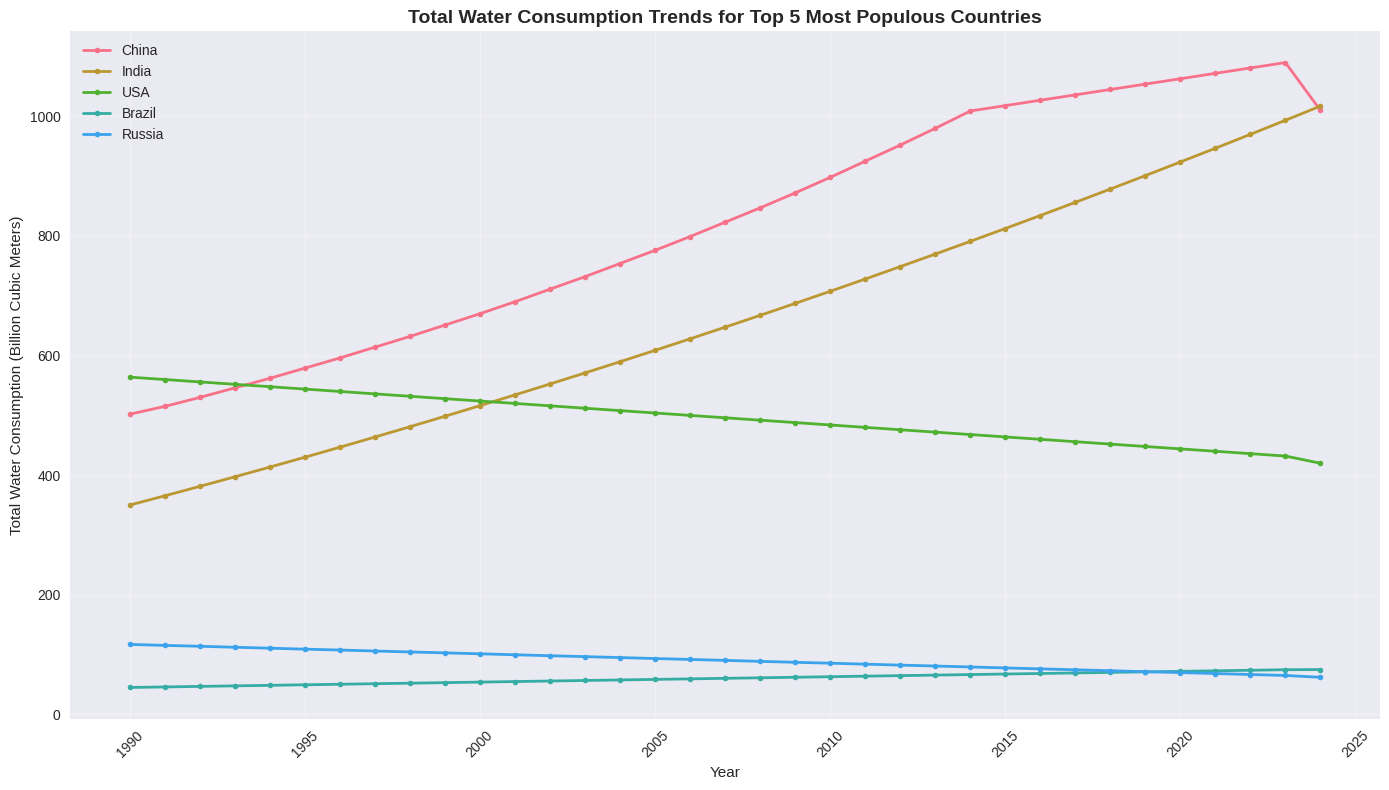

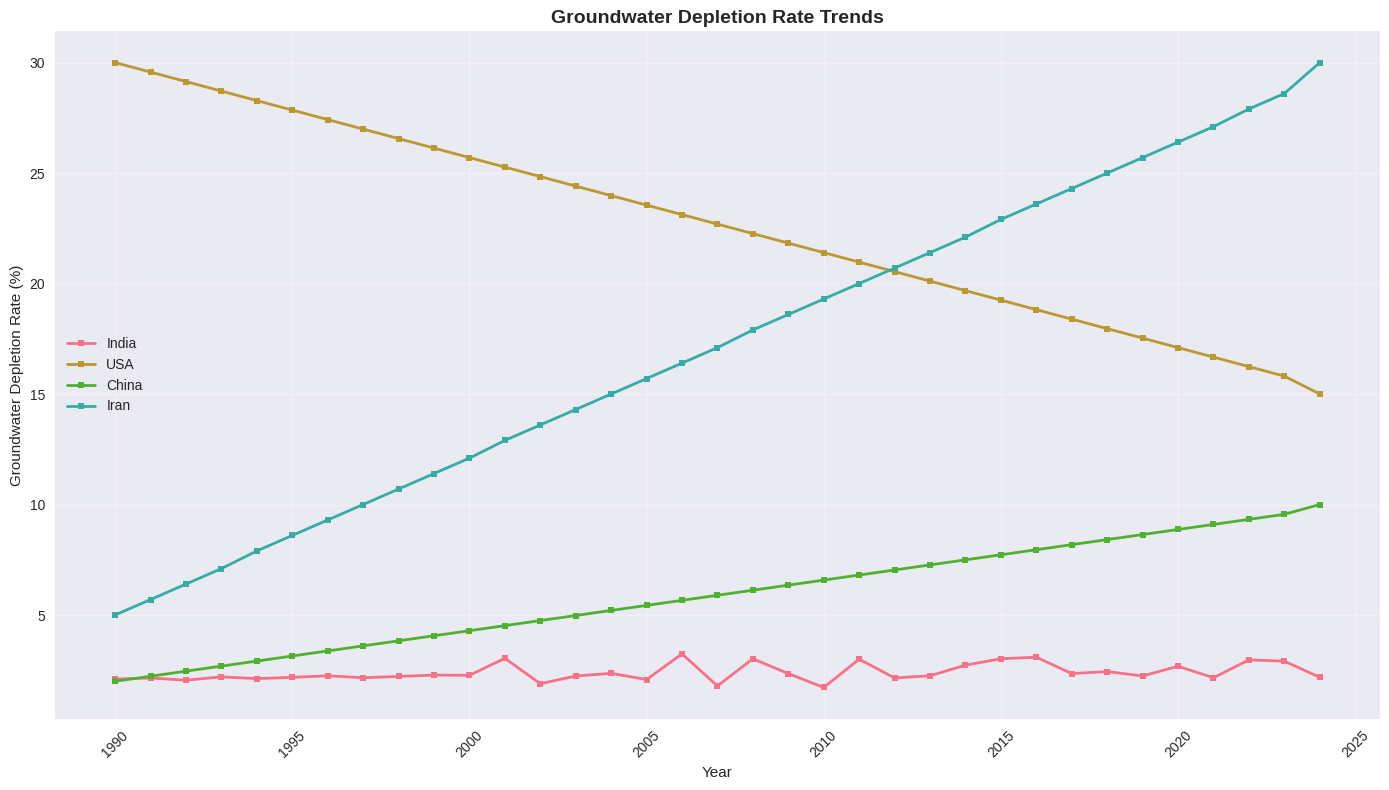

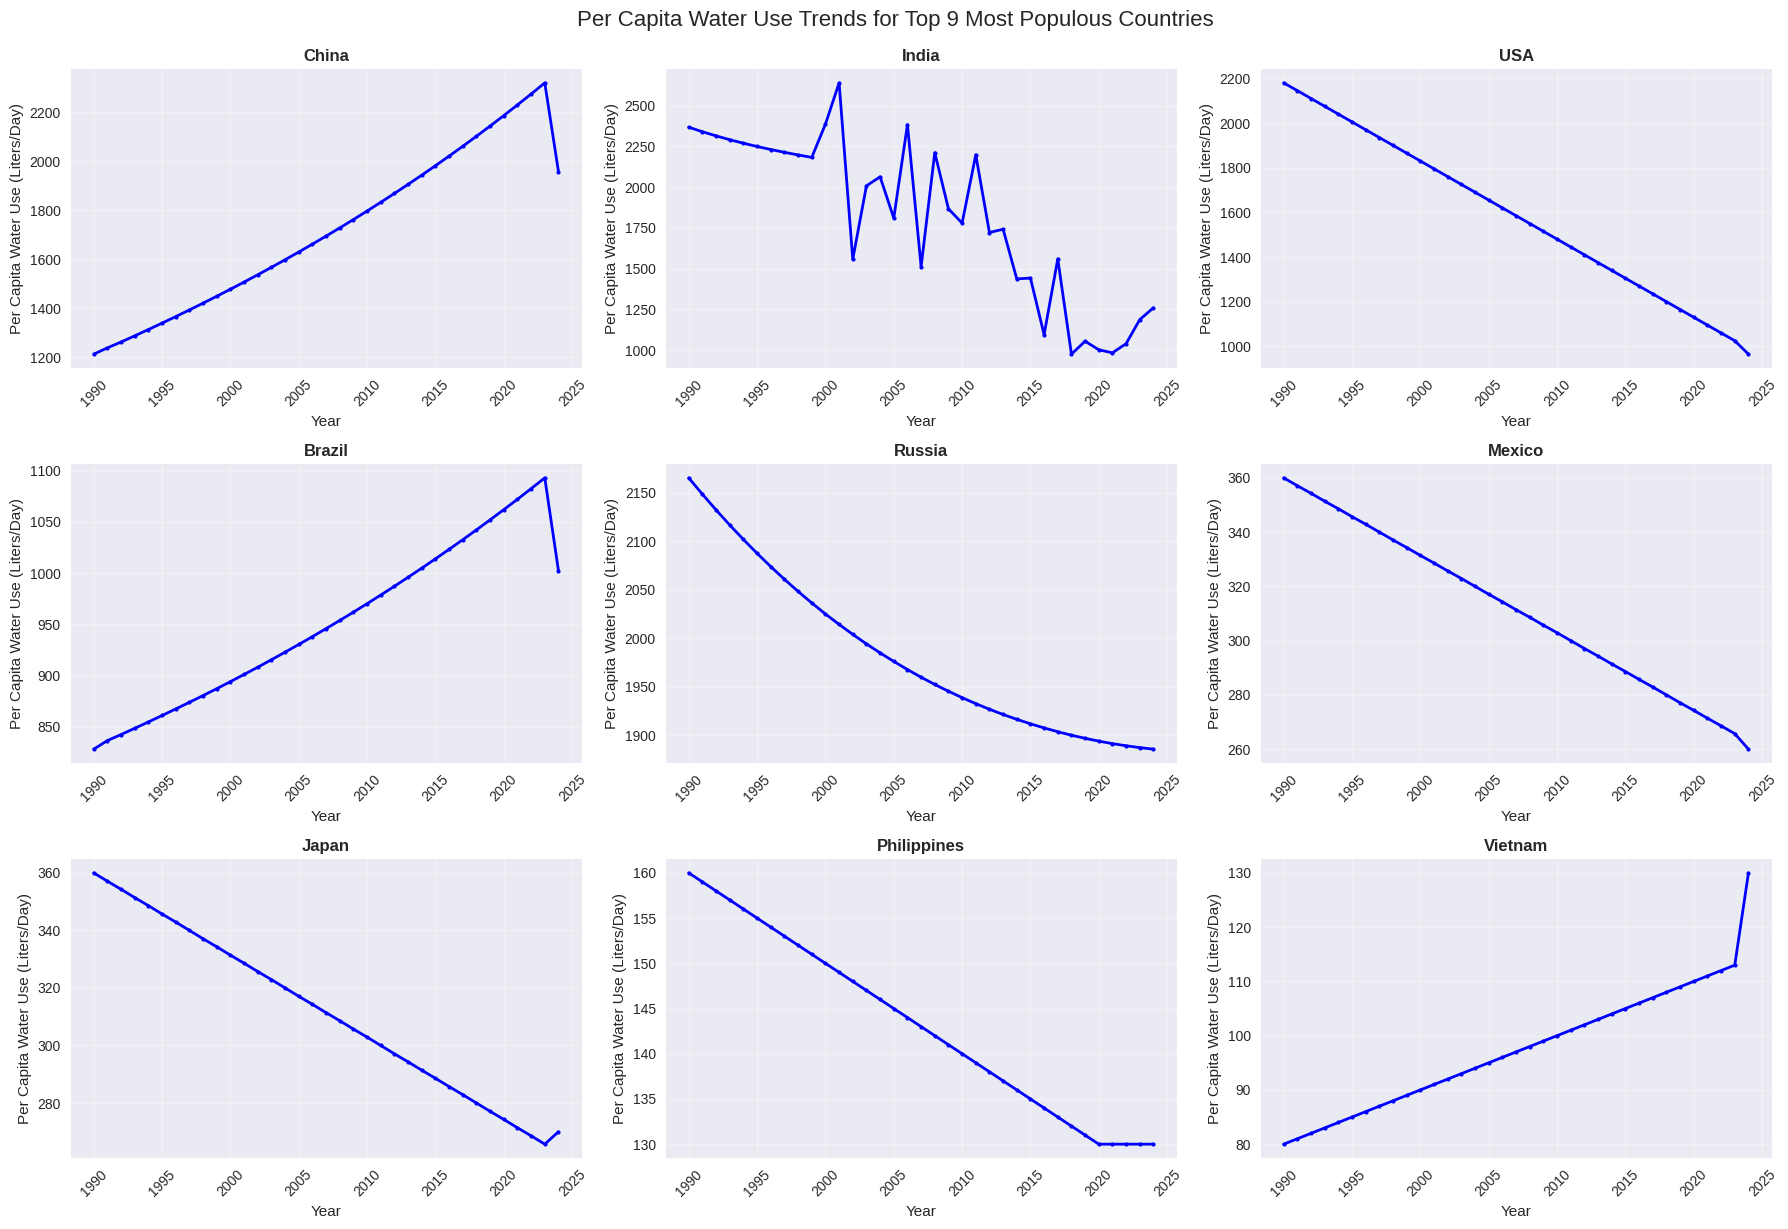

In [62]:
# B1. Line Charts for top 5 most populous countries (based on latest data)
latest_year = df['Year'].max()
latest_pop = df[df['Year'] == latest_year].nlargest(5, 'Population')['Country'].tolist()

plt.figure(figsize=(14, 8))
for country in latest_pop:
    country_data = df[df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Total Water Consumption(Billion Cubic Meters)'],
             marker='o', linewidth=2, label=country, markersize=4)

plt.title('Total Water Consumption Trends for Top 5 Most Populous Countries', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Water Consumption (Billion Cubic Meters)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# B2. Groundwater Depletion Rate comparison for specific countries
comparison_countries = ['India', 'USA', 'China', 'Iran', 'Pakistan']
plt.figure(figsize=(14, 8))

for country in comparison_countries:
    if country in df['Country'].unique():
        country_data = df[df['Country'] == country]
        plt.plot(country_data['Year'], country_data['Groundwater Depletion Rate (%)'],
                 marker='s', linewidth=2, label=country, markersize=4)

plt.title('Groundwater Depletion Rate Trends', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Groundwater Depletion Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# B3. Small Multiples / Faceted Plots for Per Capita Water Use
top_countries = df[df['Year'] == latest_year].nlargest(9, 'Population')['Country'].tolist()
top_countries_data = df[df['Country'].isin(top_countries)]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, country in enumerate(top_countries):
    country_data = top_countries_data[top_countries_data['Country'] == country]
    axes[i].plot(country_data['Year'], country_data['Per Capita Water Use (Liters per Day)'],
                color='blue', linewidth=2, marker='o', markersize=3)
    axes[i].set_title(country, fontweight='bold')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Per Capita Water Use (Liters/Day)')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Per Capita Water Use Trends for Top 9 Most Populous Countries', fontsize=16, y=1.02)
plt.show()

Summary Statistics for Key Variables:
         Population  Total Water Consumption(Billion Cubic Meters)  \
count  7.000000e+02                                     700.000000   
mean   1.792414e+08                                     144.854971   
std    3.138277e+08                                     231.727633   
min    2.100000e+05                                      14.000000   
25%    3.737500e+07                                      37.175000   
50%    6.904143e+07                                      61.300000   
75%    1.330786e+08                                      83.100000   
max    1.460000e+09                                    1090.000000   

       Per Capita Water Use (Liters per Day)  \
count                             700.000000   
mean                              718.603043   
std                               654.941590   
min                                80.000000   
25%                               197.700000   
50%                               438.50000

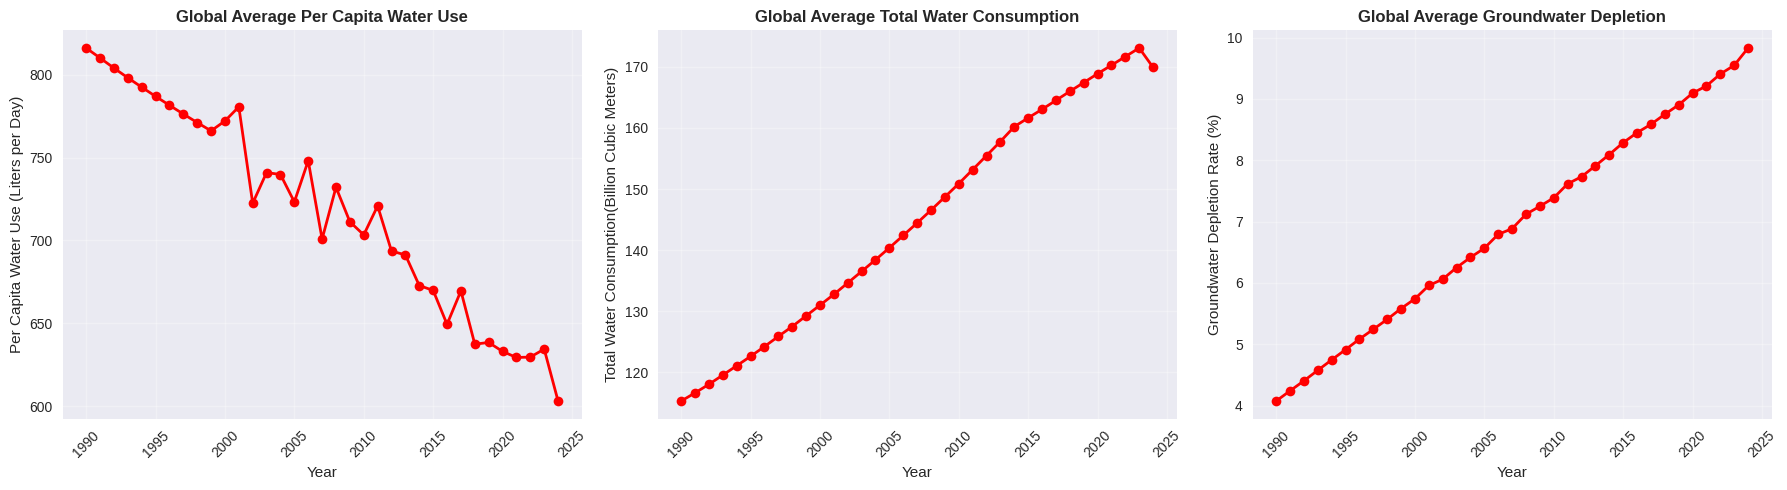

In [63]:
# C1. Static Choropleth Map for Water Scarcity Level in 2020
# First, let's create a country code mapping for plotly
country_code_mapping = {
    'India': 'IND', 'China': 'CHN', 'USA': 'USA', 'Brazil': 'BRA', 'Russia': 'RUS',
    'Mexico': 'MEX', 'Australia': 'AUS', 'England': 'GBR', 'France': 'FRA', 'Canada': 'CAN',
    'Japan': 'JPN', 'Argentina': 'ARG', 'Vietnam': 'VNM', 'Philippines': 'PHL', 'Iran': 'IRN',
    'Thailand': 'THA', 'Uzbekistan': 'UZB', 'Turkey': 'TUR', 'Peru': 'PER', 'Iraq': 'IRQ'
}

# Add ISO codes to dataframe
df['ISO_Code'] = df['Country'].map(country_code_mapping)

# Create 2020 data subset
df_2020 = df[df['Year'] == 2020].copy()

# Create color mapping for water scarcity levels
scarcity_color_map = {'Low': 'green', 'Moderate': 'orange', 'High': 'red'}

# Choropleth map for 2020
fig = px.choropleth(df_2020,
                    locations="ISO_Code",
                    color="Water Scarcity Level",
                    hover_name="Country",
                    hover_data=["Population", "Total Water Consumption(Billion Cubic Meters)"],
                    color_discrete_map=scarcity_color_map,
                    title="Global Water Scarcity Levels in 2020",
                    projection="natural earth")

fig.update_layout(height=600, title_x=0.5)
fig.show()

# C2. Interactive time-series choropleth for Per Capita Water Use
fig = px.choropleth(df,
                    locations="ISO_Code",
                    color="Per Capita Water Use (Liters per Day)",
                    hover_name="Country",
                    animation_frame="Year",
                    range_color=[df["Per Capita Water Use (Liters per Day)"].min(),
                                df["Per Capita Water Use (Liters per Day)"].max()],
                    color_continuous_scale=px.colors.sequential.Blues,
                    title="Evolution of Per Capita Water Use (1990-2024)",
                    projection="natural earth")

fig.update_layout(height=600, title_x=0.5)
fig.show()

# Alternative: Create an animated map using a slider (more control)
latest_data = df[df['Year'].isin([1990, 2000, 2010, 2020, 2024])]

fig = go.Figure()

years = sorted(latest_data['Year'].unique())
for i, year in enumerate(years):
    year_data = latest_data[latest_data['Year'] == year]

    fig.add_trace(go.Choropleth(
        locations=year_data['ISO_Code'],
        z=year_data['Per Capita Water Use (Liters per Day)'],
        text=year_data['Country'],
        colorscale='Blues',
        colorbar_title="Liters/Day",
        zmin=df["Per Capita Water Use (Liters per Day)"].min(),
        zmax=df["Per Capita Water Use (Liters per Day)"].max(),
        visible=(i==0),  # Only first trace visible initially
        name=f'Year {year}'
    ))

# Create steps and slider
steps = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * len(years)},
            # Add an empty dict for layout updates, as it's the second expected element
            {}
        ],
        label=str(year)
    )

    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title_text="Per Capita Water Use Evolution (1990-2024)",
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    sliders=sliders,
    height=600
)

fig.show()


# Summary statistics
print("Summary Statistics for Key Variables:")
print(df[['Population', 'Total Water Consumption(Billion Cubic Meters)',
          'Per Capita Water Use (Liters per Day)', 'Rainfall Impact (Annual Precipitation in mm)',
          'Groundwater Depletion Rate (%)']].describe())

# Missing values check
print("\nMissing Values:")
print(df.isnull().sum())


# Time series of average metrics globally
global_avg = df.groupby('Year').agg({
    'Per Capita Water Use (Liters per Day)': 'mean',
    'Total Water Consumption(Billion Cubic Meters)': 'mean',
    'Groundwater Depletion Rate (%)': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Per Capita Water Use (Liters per Day)', 'Total Water Consumption(Billion Cubic Meters)', 'Groundwater Depletion Rate (%)']
titles = ['Global Average Per Capita Water Use', 'Global Average Total Water Consumption', 'Global Average Groundwater Depletion']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    axes[i].plot(global_avg['Year'], global_avg[metric], linewidth=2, marker='o', color='red')
    axes[i].set_title(title, fontweight='bold')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [64]:
# print("\n=== PHASE 3: FEATURE ENGINEERING ===")
# print("=" * 60)

# # 3.1 Create Per Capita Features
# print("3.1 Create Per Capita Features")
# print("-" * 40)

# # Ensure 'Population' is numeric before calculation
# # The cleaning step in Phase 2 should handle this, but adding a safeguard here
# # to explicitly convert with error handling and imputation if necessary.
# if df['Population'].dtype == 'object':
#     print("Warning: 'Population' column is still of object type. Attempting conversion.")
#     df['Population'] = pd.to_numeric(df['Population'].str.replace(',', '').str.replace(' ', ''), errors='coerce')
#     if df['Population'].isnull().any():
#         print("Warning: Some 'Population' values could not be converted to numeric. Imputing with median.")
#         df['Population'] = df['Population'].fillna(df['Population'].median())


# # Calculate Per Capita Water Consumption
# # Ensure 'Population' is not zero to avoid division by zero errors
# df['Per Capita Water Consumption (Cubic Meters)'] = (df['Total Water Consumption(Billion Cubic Meters)'] * 1e9) / df['Population'].replace(0, np.nan) # Replace 0 population with NaN
# # Impute resulting NaNs from division by zero if needed
# if df['Per Capita Water Consumption (Cubic Meters)'].isnull().any():
#      print("Warning: Division by zero occurred in Per Capita Water Consumption calculation. Imputing resulting NaNs with median.")
#      df['Per Capita Water Consumption (Cubic Meters)'] = df['Per Capita Water Consumption (Cubic Meters)'].fillna(df['Per Capita Water Consumption (Cubic Meters)'].median())


# print("'Per Capita Water Consumption (Cubic Meters)' feature created.")

# # You can add more feature engineering steps here based on the dataset and problem

# print("\nFeature Engineering complete.")
# display(df.head())

In [65]:
# Select and create features that work well with these algorithms
def create_ml_features(df):
    df_feat = df.copy()

    # Basic features (avoid too many correlated features for LASSO/Ridge)
    df_feat['Water_Use_Intensity'] = df_feat['Total Water Consumption(Billion Cubic Meters)'] / df_feat['Population']
    df_feat['Sector_Balance'] = df_feat['Industrial Water Use (%)'] / (df_feat['Agricultural Water Use (%)'] + 1)
    df_feat['Infrastructure_per_Capita'] = df_feat['Reservoir_Capacity_TMC'] / (df_feat['Population'] + 1)

    # Lag features (simple time-series)
    df_feat['Water_Consumption_lag1'] = df_feat.groupby('Country')['Total Water Consumption(Billion Cubic Meters)'].shift(1)
    df_feat['Per_Capita_lag1'] = df_feat.groupby('Country')['Per Capita Water Use (Liters per Day)'].shift(1)

    # Rolling averages (3-year)
    df_feat['Water_Consumption_MA3'] = df_feat.groupby('Country')['Total Water Consumption(Billion Cubic Meters)'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)

    # Interaction terms (limited to avoid multicollinearity)
    df_feat['Population_Rainfall_Interaction'] = df_feat['Population'] * df_feat['Rainfall Impact (Annual Precipitation in mm)']
    df_feat['Agri_GW_Interaction'] = df_feat['Agricultural Water Use (%)'] * df_feat['Groundwater Depletion Rate (%)']

    return df_feat

df_ml = create_ml_features(df)

# Select final feature set (avoid highly correlated features for LASSO/Ridge)
feature_columns = [
    'Population', 'Total Water Consumption(Billion Cubic Meters)',
    'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)',
    'Industrial Water Use (%)', 'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)',
    'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries',
    'Water_Use_Intensity', 'Sector_Balance', 'Infrastructure_per_Capita',
    'Water_Consumption_lag1', 'Per_Capita_lag1', 'Water_Consumption_MA3',
    'Population_Rainfall_Interaction', 'Agri_GW_Interaction'
]

# Fill any remaining missing values using the median
for col in feature_columns:
    if col in df_ml.columns and df_ml[col].isnull().any():
        df_ml[col].fillna(df_ml[col].median(), inplace=True)

print(f"Final dataset shape: {df_ml.shape}")
print(f"Number of features: {len(feature_columns)}")

print("\nHead of DataFrame with new features:")
# Set pandas display option to suppress scientific notation for floats
pd.set_option('display.float_format', '{:.2f}'.format)
display(df_ml.head())
# Reset pandas display option to default
pd.reset_option('display.float_format')

print("\nDataFrame Info with new features:")
df_ml.info()

Final dataset shape: (700, 24)
Number of features: 19

Head of DataFrame with new features:


,Year,Country code,Country,Population,Total Water Consumption(Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),...,Number_of_Industries,ISO_Code,Water_Use_Intensity,Sector_Balance,Infrastructure_per_Capita,Water_Consumption_lag1,Per_Capita_lag1,Water_Consumption_MA3,Population_Rainfall_Interaction,Agri_GW_Interaction
0,1990,356,India,405123000,350.00,2367.85,39.50,37.20,23.30,1615.80,...,8800,IND,0.00,0.92,0.00,61.30,441.00,350.00,654597743400.00,82.95
1,1990,156,China,1130000000,502.00,1212.14,84.00,37.20,5.00,640.00,...,126000,CHN,0.00,0.44,0.00,61.30,441.00,502.00,723200000000.00,168.00
2,1990,840,USA,249000000,564.00,2180.00,65.00,45.00,12.00,715.00,...,380000,USA,0.00,0.68,0.00,61.30,441.00,564.00,178035000000.00,1950.00
3,1990,76,Brazil,149000000,45.00,827.90,60.00,20.00,10.00,2200.00,...,130000,BRA,0.00,0.33,0.00,61.30,441.00,45.00,327800000000.00,120.00
4,1990,643,Russia,148000000,117.00,2165.50,35.00,45.00,10.00,460.00,...,45000,RUS,0.00,1.25,0.00,61.30,441.00,117.00,68080000000.00,245.00



DataFrame Info with new features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Year                                           700 non-null    int64  
 1   Country code                                   700 non-null    int64  
 2   Country                                        700 non-null    object 
 3   Population                                     700 non-null    int64  
 4   Total Water Consumption(Billion Cubic Meters)  700 non-null    float64
 5   Per Capita Water Use (Liters per Day)          700 non-null    float64
 6   Agricultural Water Use (%)                     700 non-null    float64
 7   Industrial Water Use (%)                       700 non-null    float64
 8   Household Water Use (%)                        700 non-null    float64
 9   Rainfall Impact (An

In [66]:
print("\n=== PHASE 5: DATA SPLITTING ===")
print("=" * 60)

# 5.1 Split Data
print("5.1 Split Data into Training and Testing Sets")
print("-" * 40)

# Define target variable and features
TARGET = 'Total Water Consumption(Billion Cubic Meters)'
y = df_ml[TARGET]
X = df_ml.drop(columns=[TARGET, 'Year', 'Country code', 'ISO_Code', 'Country'])

# Identify numerical and categorical features for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_ml.select_dtypes(include='object').columns.drop(['Country', 'ISO_Code']).tolist()
# Exclude 'Country' and 'ISO_Code' as they are not used as features directly in X or handled differently

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns not specified (if any)
)

# Apply preprocessing to X
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding and scaling
# If using a pipeline, we'd typically get feature names from the preprocessor step in the pipeline
# For now, let's just make sure the shapes match for splitting.

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

print("\nData splitting complete.")


=== PHASE 5: DATA SPLITTING ===
5.1 Split Data into Training and Testing Sets
----------------------------------------
Training features shape: (560, 21)
Testing features shape: (140, 21)
Training target shape: (560,)
Testing target shape: (140,)

Data splitting complete.


K-NEAREST NEIGHBORS (KNN) MODEL TRAINING
Training KNN model with GridSearchCV...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best KNN parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best KNN cross-validation score: 672.3671 (Negative MSE)

KNN Model Performance Metrics:
----------------------------------------
RMSE: 14.45
MAE: 3.98
R² Score: 0.9964
MAPE: 1.08%

KNN Predictions Summary:
------------------------------
Mean Absolute Error: 3.98
Max Absolute Error: 98.53
Mean Percentage Error: 1.08%

KNN Model Insights:
------------------------------
Optimal number of neighbors: 3
Optimal weight function: distance
Optimal distance metric: manhattan

Top 5 KNN parameter combinations by CV score:
Score: 672.3671 ± 460.2175
Score: 672.3671 ± 460.2175
Score: 672.3671 ± 460.2175
Score: 838.0477 ± 528.1858
Score: 838.0477 ± 528.1858


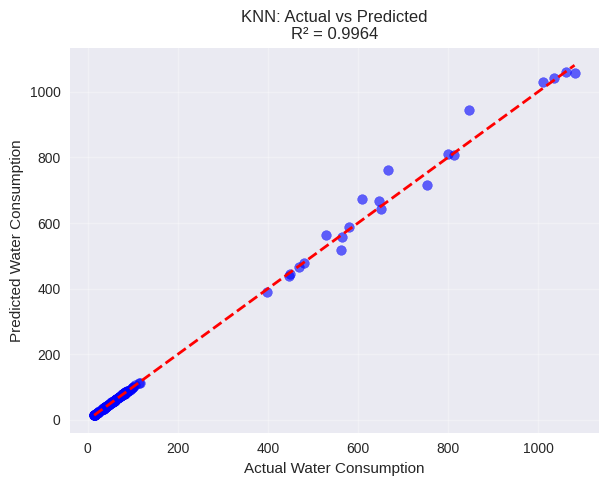

In [67]:
# KNN Model Training
print("=" * 70)
print("K-NEAREST NEIGHBORS (KNN) MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train KNN model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit # Import TimeSeriesSplit

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Define parameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # Power parameter for Minkowski metric
}

### 2. Instantiate GridSearchCV
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training KNN model with GridSearchCV...")
knn_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest KNN parameters: {knn_grid.best_params_}")
print(f"Best KNN cross-validation score: {-knn_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_knn = knn_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_knn = best_knn.predict(X_test)

### 7. Evaluate the tuned model's performance
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_mae = mean_absolute_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)
knn_mape = np.mean(np.abs((y_test - y_pred_knn) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned KNN model
print("\nKNN Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {knn_rmse:.2f}")
print(f"MAE: {knn_mae:.2f}")
print(f"R² Score: {knn_r2:.4f}")
print(f"MAPE: {knn_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
knn_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_knn,
    'Absolute_Error': np.abs(y_test.values - y_pred_knn),
    'Percentage_Error': (np.abs(y_test.values - y_pred_knn) / y_test.values) * 100
})

# Sort by original values for better visualization
knn_comparison_df_sorted = knn_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nKNN Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {knn_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {knn_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {knn_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'KNN: Actual vs Predicted\nR² = {knn_r2:.4f}')
plt.grid(True, alpha=0.3)

# # Plot 2: Sorted values comparison
# plt.subplot(1, 2, 2)
# plt.plot(knn_comparison_df_sorted['Actual'], label='Actual', marker='o', markersize=3)
# plt.plot(knn_comparison_df_sorted['Predicted'], label='Predicted', marker='s', markersize=3)
# plt.xlabel('Sorted Test Samples')
# plt.ylabel('Water Consumption')
# plt.title('KNN: Sorted Actual vs Predicted Values')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# Additional KNN-specific analysis
print("\nKNN Model Insights:")
print("-" * 30)
print(f"Optimal number of neighbors: {knn_grid.best_params_['knn__n_neighbors']}")
print(f"Optimal weight function: {knn_grid.best_params_['knn__weights']}")
print(f"Optimal distance metric: {knn_grid.best_params_['knn__metric']}")

# Cross-validation results analysis
knn_cv_results = pd.DataFrame(knn_grid.cv_results_)
print(f"\nTop 5 KNN parameter combinations by CV score:")
top_knn_params = knn_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_knn_params.iterrows():
    print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")


RIDGE REGRESSION MODEL TRAINING
Training Ridge model with GridSearchCV...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits

Best Ridge parameters: {'ridge__alpha': 0.01, 'ridge__max_iter': 1000, 'ridge__solver': 'lsqr'}
Best Ridge cross-validation score: 6.7397 (Negative MSE)

Ridge Model Performance Metrics:
----------------------------------------
RMSE: 6.52
MAE: 1.77
R² Score: 0.9993
MAPE: 1.37%

Ridge Predictions Summary:
------------------------------
Mean Absolute Error: 1.77
Max Absolute Error: 69.95
Mean Percentage Error: 1.37%

Top 10 Most Important Features (Ridge Coefficients):
--------------------------------------------------
Water_Consumption_MA3               : 217.136892
Water_Consumption_lag1              :   8.080785
Population                          :   3.669161
Household Water Use (%)             :   1.439859
Number of dams                      :  -1.366597
Population_Rainfall_Interaction     :   1.326691
Number_of_Industries                :  -1.2

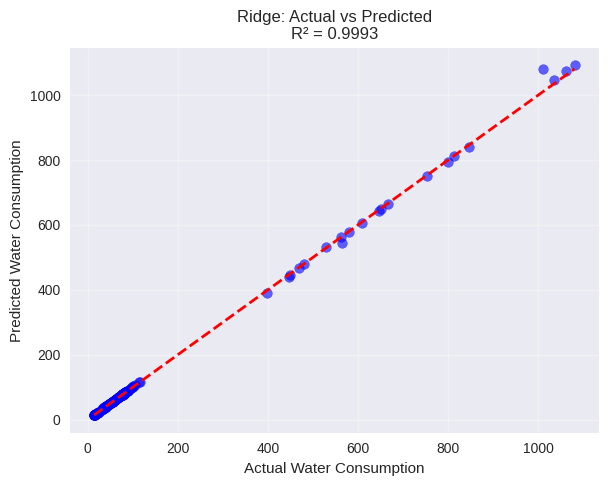

In [68]:
# Ridge Model Training
print("\n" + "=" * 70)
print("RIDGE REGRESSION MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train Ridge model
from sklearn.linear_model import Ridge

# Create Ridge pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Define parameter grid for Ridge
ridge_param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
    'ridge__max_iter': [1000, 5000, 10000]
}

### 2. Instantiate GridSearchCV
ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training Ridge model with GridSearchCV...")
ridge_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest Ridge parameters: {ridge_grid.best_params_}")
print(f"Best Ridge cross-validation score: {-ridge_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_ridge = ridge_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_ridge = best_ridge.predict(X_test)

### 7. Evaluate the tuned model's performance
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned Ridge model
print("\nRidge Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {ridge_rmse:.2f}")
print(f"MAE: {ridge_mae:.2f}")
print(f"R² Score: {ridge_r2:.4f}")
print(f"MAPE: {ridge_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
ridge_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_ridge,
    'Absolute_Error': np.abs(y_test.values - y_pred_ridge),
    'Percentage_Error': (np.abs(y_test.values - y_pred_ridge) / y_test.values) * 100
})

# Sort by original values for better visualization
ridge_comparison_df_sorted = ridge_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nRidge Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {ridge_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {ridge_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {ridge_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'Ridge: Actual vs Predicted\nR² = {ridge_r2:.4f}')
plt.grid(True, alpha=0.3)


# Ridge coefficients analysis
ridge_model = best_ridge.named_steps['ridge']

# Get feature names after one-hot encoding, excluding 'Country code'
feature_names_out = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Ensure the number of feature names matches the number of coefficients
if len(feature_names_out) != len(ridge_model.coef_):
    print("Warning: Number of feature names does not match the number of coefficients.")
    # Attempt to align by excluding 'Country code' from the final feature list if it's still there
    if 'Country code' in feature_names_out:
        feature_names_out.remove('Country code')

# Re-check the length after potential removal
if len(feature_names_out) != len(ridge_model.coef_):
    print("Error: Unable to align feature names and coefficients.")
else:
    ridge_coefficients = pd.DataFrame({
        'Feature': feature_names_out,
        'Coefficient': ridge_model.coef_,
        'Absolute_Coefficient': np.abs(ridge_model.coef_)
    }).sort_values('Absolute_Coefficient', ascending=False)

    print("\nTop 10 Most Important Features (Ridge Coefficients):")
    print("-" * 50)
    for idx, row in ridge_coefficients.head(10).iterrows():
        print(f"{row['Feature']:35} : {row['Coefficient']:10.6f}")


# Additional Ridge-specific analysis
print(f"\nRidge Model Insights:")
print("-" * 30)
print(f"Optimal alpha (regularization strength): {ridge_grid.best_params_['ridge__alpha']}")
print(f"Optimal solver: {ridge_grid.best_params_['ridge__solver']}")
print(f"Number of iterations: {ridge_grid.best_params_['ridge__max_iter']}")

# Cross-validation results analysis
ridge_cv_results = pd.DataFrame(ridge_grid.cv_results_)
print(f"\nTop 5 Ridge parameter combinations by CV score:")
top_ridge_params = ridge_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_ridge_params.iterrows():
    print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")

LASSO REGRESSION MODEL TRAINING
Training LASSO model with GridSearchCV...
Fitting 5 folds for each of 168 candidates, totalling 840 fits

Best LASSO parameters: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000, 'lasso__selection': 'random', 'lasso__tol': 1e-05}
Best LASSO cross-validation score: 6.1781 (Negative MSE)

LASSO Model Performance Metrics:
----------------------------------------
RMSE: 6.48
MAE: 1.80
R² Score: 0.9993
MAPE: 1.43%

LASSO Predictions Summary:
------------------------------
Mean Absolute Error: 1.80
Max Absolute Error: 69.37
Mean Percentage Error: 1.43%


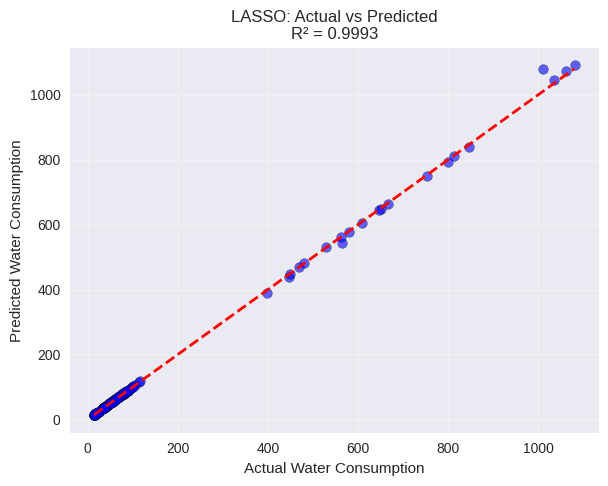

In [69]:
# LASSO Model Training
print("=" * 70)
print("LASSO REGRESSION MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train LASSO model
from sklearn.linear_model import Lasso

# Create LASSO pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Define parameter grid for LASSO
lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'lasso__max_iter': [1000, 5000, 10000],
    'lasso__selection': ['cyclic', 'random'],
    'lasso__tol': [1e-4, 1e-5]
}

### 2. Instantiate GridSearchCV
lasso_grid = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training LASSO model with GridSearchCV...")
lasso_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest LASSO parameters: {lasso_grid.best_params_}")
print(f"Best LASSO cross-validation score: {-lasso_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_lasso = lasso_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_lasso = best_lasso.predict(X_test)

### 7. Evaluate the tuned model's performance
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned LASSO model
print("\nLASSO Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {lasso_rmse:.2f}")
print(f"MAE: {lasso_mae:.2f}")
print(f"R² Score: {lasso_r2:.4f}")
print(f"MAPE: {lasso_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
lasso_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_lasso,
    'Absolute_Error': np.abs(y_test.values - y_pred_lasso),
    'Percentage_Error': (np.abs(y_test.values - y_pred_lasso) / y_test.values) * 100
})

# Sort by original values for better visualization
lasso_comparison_df_sorted = lasso_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nLASSO Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {lasso_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {lasso_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {lasso_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso, alpha=0.6,edgecolor='black', color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'LASSO: Actual vs Predicted\nR² = {lasso_r2:.4f}')
plt.grid(True, alpha=0.3)

# # Plot 2: Sorted values comparison
# plt.subplot(1, 2, 2)
# plt.plot(lasso_comparison_df_sorted['Actual'], label='Actual', marker='o', markersize=3)
# plt.plot(lasso_comparison_df_sorted['Predicted'], label='Predicted', marker='s', markersize=3)
# plt.xlabel('Sorted Test Samples')
# plt.ylabel('Water Consumption')
# plt.title('LASSO: Sorted Actual vs Predicted Values')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [70]:
# LASSO Feature Analysis and Coefficients
print("\n" + "=" * 70)
print("LASSO FEATURE ANALYSIS AND COEFFICIENTS")
print("=" + "=" * 70)

### Extract LASSO coefficients for analysis
lasso_model = best_lasso.named_steps['lasso']

# Get feature names after preprocessing
# Access the fitted preprocessor
fitted_preprocessor = preprocessor.fit(X, y)

# Get the transformed column names directly from the fitted preprocessor
# This will include all columns from the output of the ColumnTransformer
all_processed_features_out = fitted_preprocessor.get_feature_names_out()

# Ensure the number of feature names matches the number of coefficients from the Lasso model
if len(all_processed_features_out) != len(lasso_model.coef_):
    print(f"Error: Mismatch between number of feature names ({len(all_processed_features_out)}) and coefficients ({len(lasso_model.coef_)}).")
    # Attempt to diagnose further if needed
else:
    # Create comprehensive coefficient analysis
    lasso_coefficients = pd.DataFrame({
        'Feature': all_processed_features_out,
        'Coefficient': lasso_model.coef_,
        'Absolute_Coefficient': np.abs(lasso_model.coef_),
        'Is_Selected': lasso_model.coef_ != 0
    }).sort_values('Absolute_Coefficient', ascending=False)

    # Feature selection summary
    n_total = len(lasso_coefficients)
    n_selected = lasso_coefficients['Is_Selected'].sum()
    n_excluded = n_total - n_selected

    print(f"Feature Selection Summary:")
    print("-" * 30)
    print(f"Total Features: {n_total}")
    print(f"Selected Features (non-zero): {n_selected} ({n_selected/n_total*100:.1f}%)")
    print(f"Excluded Features (zero): {n_excluded} ({n_excluded/n_total*100:.1f}%)")

    # Display top coefficients
    print(f"\nTop 10 Most Important Features (LASSO Coefficients):")
    print("-" * 50)
    for idx, row in lasso_coefficients.head(10).iterrows():
        status = "SELECTED" if row['Is_Selected'] else "EXCLUDED"
        print(f"{row['Feature']:35} : {row['Coefficient']:10.6f} ({status})")

    # Display excluded features
    excluded_features = lasso_coefficients[~lasso_coefficients['Is_Selected']]
    if len(excluded_features) > 0:
        print(f"\nExcluded Features (Zero Coefficients):")
        print("-" * 40)
        for feature in excluded_features['Feature']:
            print(f"  {feature}")

    # Additional LASSO-specific analysis
    print(f"\nLASSO Model Insights:")
    print("-" * 30)
    print(f"Optimal alpha (regularization strength): {lasso_grid.best_params_['lasso__alpha']}")
    print(f"Optimal selection method: {lasso_grid.best_params_['lasso__selection']}")
    print(f"Number of iterations: {lasso_grid.best_params_['lasso__max_iter']}")

    # Cross-validation results analysis
    lasso_cv_results = pd.DataFrame(lasso_grid.cv_results_)
    print(f"\nTop 5 LASSO parameter combinations by CV score:")
    top_lasso_params = lasso_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
    for idx, row in top_lasso_params.iterrows():
        print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")


LASSO FEATURE ANALYSIS AND COEFFICIENTS
Feature Selection Summary:
------------------------------
Total Features: 21
Selected Features (non-zero): 13 (61.9%)
Excluded Features (zero): 8 (38.1%)

Top 10 Most Important Features (LASSO Coefficients):
--------------------------------------------------
num__Water_Consumption_MA3          : 217.002583 (SELECTED)
num__Water_Consumption_lag1         :   7.766670 (SELECTED)
num__Population                     :   3.777698 (SELECTED)
num__Population_Rainfall_Interaction :   1.687211 (SELECTED)
num__Number of dams                 :  -1.254854 (SELECTED)
num__Number_of_Industries           :  -0.833624 (SELECTED)
num__Household Water Use (%)        :   0.334328 (SELECTED)
num__Infrastructure_per_Capita      :   0.329355 (SELECTED)
num__Reservoir_Capacity_TMC         :   0.138305 (SELECTED)
cat__Water Scarcity Level_Moderate  :   0.125526 (SELECTED)

Excluded Features (Zero Coefficients):
----------------------------------------
  num__Industrial 

In [71]:
# LASSO Model Interpretation
print("\n" + "=" * 70)
print("LASSO MODEL INTERPRETATION")
print("=" + "=" * 70)

# Business insights from LASSO model
print("\nBUSINESS INSIGHTS FROM LASSO MODEL:")
print("-" * 50)

# Define positive and negative drivers based on coefficients
positive_drivers = lasso_coefficients[lasso_coefficients['Coefficient'] > 0].sort_values('Coefficient', ascending=False)
negative_drivers = lasso_coefficients[lasso_coefficients['Coefficient'] < 0].sort_values('Coefficient', ascending=True)


# Key drivers analysis
if len(positive_drivers) > 0:
    top_positive = positive_drivers.iloc[0]
    print(f"STRONGEST POSITIVE DRIVER:")
    print(f"   • Feature: {top_positive['Feature']}")
    print(f"   • Impact: Each unit increases consumption by {top_positive['Coefficient']:.4f} billion cubic meters")
    print(f"   • Interpretation: This is the most significant factor increasing water demand")

if len(negative_drivers) > 0:
    top_negative = negative_drivers.iloc[0]
    print(f"\nSTRONGEST NEGATIVE DRIVER:")
    print(f"   • Feature: {top_negative['Feature']}")
    print(f"   • Impact: Each unit decreases consumption by {abs(top_negative['Coefficient']):.4f} billion cubic meters")
    print(f"   • Interpretation: This is the most significant factor reducing water demand")

# Model efficiency
print(f"\nMODEL EFFICIENCY:")
print(f"   • Features reduced by: {n_excluded}/{n_total} ({n_excluded/n_total*100:.1f}%)")
print(f"   • Model complexity: Reduced from {n_total} to {n_selected} features")
print(f"   • Performance: R² = {lasso_r2:.4f} with simplified model")

# Practical recommendations
print(f"\nPRACTICAL RECOMMENDATIONS:")
print(f"   1. Focus monitoring on the {n_selected} selected features")
print(f"   2. Prioritize interventions based on coefficient magnitudes")
print(f"   3. Consider removing {n_excluded} excluded features from data collection")
print(f"   4. Use this sparse model for interpretable forecasting")

# Risk assessment
print(f"\nRISK ASSESSMENT:")
print(f"   • Average prediction error: ±{lasso_mae:.2f} billion cubic meters")
print(f"   • Maximum observed error: {lasso_comparison_df['Absolute_Error'].max():.2f} billion cubic meters")
print(f"   • Relative accuracy: {100 - lasso_mape:.1f}% on average")


LASSO MODEL INTERPRETATION

BUSINESS INSIGHTS FROM LASSO MODEL:
--------------------------------------------------
STRONGEST POSITIVE DRIVER:
   • Feature: num__Water_Consumption_MA3
   • Impact: Each unit increases consumption by 217.0026 billion cubic meters
   • Interpretation: This is the most significant factor increasing water demand

STRONGEST NEGATIVE DRIVER:
   • Feature: num__Number of dams
   • Impact: Each unit decreases consumption by 1.2549 billion cubic meters
   • Interpretation: This is the most significant factor reducing water demand

MODEL EFFICIENCY:
   • Features reduced by: 8/21 (38.1%)
   • Model complexity: Reduced from 21 to 13 features
   • Performance: R² = 0.9993 with simplified model

PRACTICAL RECOMMENDATIONS:
   1. Focus monitoring on the 13 selected features
   2. Prioritize interventions based on coefficient magnitudes
   3. Consider removing 8 excluded features from data collection
   4. Use this sparse model for interpretable forecasting

RISK ASSES

In [72]:
# Create a dictionary to store the metrics for each model
model_comparison = {
    'Model': ['KNN', 'Ridge', 'LASSO'],
    'RMSE': [knn_rmse, ridge_rmse, lasso_rmse],
    'MAE': [knn_mae, ridge_mae, lasso_mae],
    'R2 Score': [knn_r2, ridge_r2, lasso_r2]

}

# Create a pandas DataFrame from the dictionary
model_comparison_df = pd.DataFrame(model_comparison)

# Set 'Model' as the index for better readability
model_comparison_df.set_index('Model', inplace=True)



# Display the comparison table
print("\n=== Model Comparison Table ===")
print("=" * 30)
display(model_comparison_df)

# Reset pandas display option to default if needed elsewhere (optional)
pd.reset_option('display.float_format')

print("\nModel comparison complete.")


=== Model Comparison Table ===


,RMSE,MAE,R2 Score
Model,,,
KNN,14.446582,3.975933,0.996428
Ridge,6.518509,1.774949,0.999273
LASSO,6.483567,1.800642,0.999281



Model comparison complete.


In [73]:
# List of features the user is interested in
user_features = [
    'Population',
    'Per Capita Water Use (Liters per Day)',
    'Agricultural Water Use (%)',
    'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)',
    'Groundwater Depletion Rate (%)',
    'Water Scarcity Level',
    'Number of dams',
    'Reservoir_Capacity_TMC',
    'Number_of_Industries'
]

# Get the lasso coefficients DataFrame (assuming it's already created in a previous cell)
# Make sure the 'Feature' column in lasso_coefficients matches the format of user_features

# Filter the lasso_coefficients DataFrame for the user's listed features
# Need to handle the naming convention from the preprocessor (e.g., 'num__Population', 'cat__Water Scarcity Level_Low')
filtered_coefficients = lasso_coefficients[
    lasso_coefficients['Feature'].apply(lambda x: any(feat in x for feat in user_features))
].copy() # Use .copy() to avoid SettingWithCopyWarning

print("LASSO Coefficients for Specified Features:")
print("-" * 50)

# Display the filtered coefficients
# Including the 'Is_Selected' column to show if the coefficient is zero
display(filtered_coefficients[['Feature', 'Coefficient', 'Is_Selected']])

print("\n'Is_Selected' column indicates if the feature's coefficient is non-zero (True) or zero (False), meaning it was shrunk by LASSO.")

LASSO Coefficients for Specified Features:
--------------------------------------------------


,Feature,Coefficient,Is_Selected
0,num__Population,3.777698,True
16,num__Population_Rainfall_Interaction,1.687211,True
7,num__Number of dams,-1.254854,True
9,num__Number_of_Industries,-0.833624,True
4,num__Household Water Use (%),0.334328,True
8,num__Reservoir_Capacity_TMC,0.138305,True
20,cat__Water Scarcity Level_Moderate,0.125526,True
2,num__Agricultural Water Use (%),0.100542,True
18,cat__Water Scarcity Level_High,-0.007854,True
1,num__Per Capita Water Use (Liters per Day),-0.000000,False



'Is_Selected' column indicates if the feature's coefficient is non-zero (True) or zero (False), meaning it was shrunk by LASSO.


In [74]:
import pickle
from google.colab import files

# Define filenames for each model
knn_filename = 'best_knn_model.pkl'
ridge_filename = 'best_ridge_model.pkl'
lasso_filename = 'best_lasso_model.pkl'

# Save the best KNN model
with open(knn_filename, 'wb') as file:
    pickle.dump(best_knn, file)
print(f"KNN model saved as {knn_filename}")

# Save the best Ridge model
with open(ridge_filename, 'wb') as file:
    pickle.dump(best_ridge, file)
print(f"Ridge model saved as {ridge_filename}")

# Save the best LASSO model
with open(lasso_filename, 'wb') as file:
    pickle.dump(best_lasso, file)
print(f"LASSO model saved as {lasso_filename}")

# Download the files
files.download(knn_filename)
files.download(ridge_filename)
files.download(lasso_filename)

print("All models downloaded successfully.")

KNN model saved as best_knn_model.pkl
Ridge model saved as best_ridge_model.pkl
LASSO model saved as best_lasso_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All models downloaded successfully.


In [75]:
from google.colab import files

# Define the filename for the processed dataset
processed_dataset_filename = 'final_processed_dataset.csv'

# Save the df_ml DataFrame to a CSV file
df_ml.to_csv(processed_dataset_filename, index=False)
print(f"Final processed dataset saved as {processed_dataset_filename}")

# Download the CSV file
files.download(processed_dataset_filename)

print("Final dataset downloaded successfully.")

Final processed dataset saved as final_processed_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final dataset downloaded successfully.


In [76]:
import pickle
from google.colab import files

# --- Save Preprocessor (Scaler and Label Encoder) ---
preprocessor_filename = 'preprocessor.pkl'
with open(preprocessor_filename, 'wb') as file:
    pickle.dump(preprocessor, file)
print(f"Preprocessor (scaler and label encoder) saved as {preprocessor_filename}")

# --- Save Feature Names ---
feature_names_filename = 'feature_names.pkl'
with open(feature_names_filename, 'wb') as file:
    pickle.dump(all_processed_features_out, file)
print(f"Feature names saved as {feature_names_filename}")

# --- Save Performance Metrics ---
# As PKL
performance_metrics_pkl_filename = 'performance_metrics.pkl'
with open(performance_metrics_pkl_filename, 'wb') as file:
    pickle.dump(model_comparison_df, file)
print(f"Performance metrics saved as {performance_metrics_pkl_filename} (PKL)")

# As CSV (as requested previously and for convenience)
performance_metrics_csv_filename = 'performance_metrics.csv'
model_comparison_df.to_csv(performance_metrics_csv_filename, index=True)
print(f"Performance metrics saved as {performance_metrics_csv_filename} (CSV)")

# --- Initiate Downloads ---
files.download(preprocessor_filename)
files.download(feature_names_filename)
files.download(performance_metrics_pkl_filename)
files.download(performance_metrics_csv_filename)

print("All requested files downloaded successfully.")

Preprocessor (scaler and label encoder) saved as preprocessor.pkl
Feature names saved as feature_names.pkl
Performance metrics saved as performance_metrics.pkl (PKL)
Performance metrics saved as performance_metrics.csv (CSV)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All requested files downloaded successfully.
